In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from collections import defaultdict
from itertools import combinations
from local.utils import daf_utils
# from matplotlib import colormaps


#### Create the DAFset class

In [2]:
# Create a DAFset class for access to pertinent methods and standard vars.  See daf_utils.py
'''Currently choosing to only analyze the first 10 sites.  The high freq. of binding at site 11 will make thermodynamic
    calculations difficult, so we choose to treat it as an insulator'''

bind_df = pd.read_csv('Data/zmw_footprint_regions_NAPA.csv', index_col=0)
bind_df.drop('11',axis=1,inplace=True)
print(bind_df.shape[0], "total samples")
bind_df.columns = np.arange(1,11)
db = daf_utils.DAFset(bind_df)
del bind_df
db.raw_df.head()

23203 total samples


,1,2,3,4,5,6,7,8,9,10
zmw,,,,,,,,,,
m84046_240619_124816_s1/200086108/ccs,0,0,1,0,0,0,0,0,0,1
m84046_240619_124816_s1/162402293/ccs,1,0,0,0,0,0,0,0,0,0
m84046_240619_124816_s1/184290934/ccs,1,0,1,0,0,0,0,1,1,0
m84046_240619_124816_s1/50858033/ccs,1,1,0,0,0,0,0,0,1,0
m84046_240619_124816_s1/173016106/ccs,1,1,1,1,0,0,0,0,1,1


#### Analyze Chromatin Stats

890 total samples containing at least site blocked by a chromatin


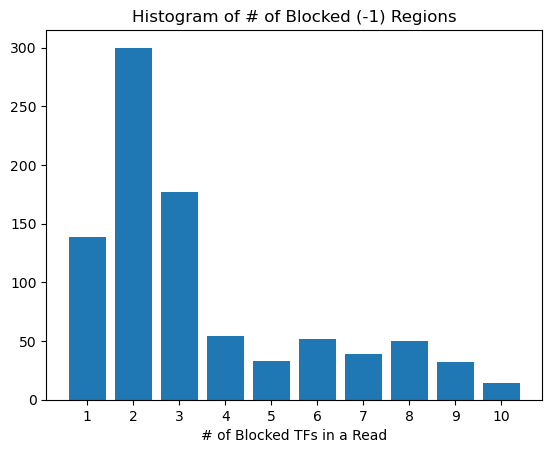

<Figure size 640x480 with 0 Axes>

In [3]:
# Analyze Chromatin Stats
print(db.hist_I.shape[0], "total samples containing at least site blocked by a chromatin")

blocked = db.data_df['num_blocked'].loc[db.hist_I].value_counts()
plt.bar(blocked.index.values,blocked.values)
plt.title('Histogram of # of Blocked (-1) Regions')
plt.xticks(np.arange(1,11))
plt.xlabel("# of Blocked TFs in a Read")
plt.show()
plt.clf()

# TODO: Place blocked region length here


#### Analyze Histogram-Free Reads and Simple TF Occurance Values

22313 total samples with no bound chromatin


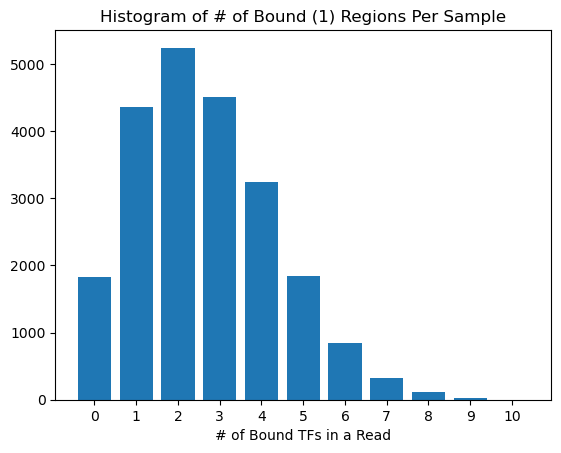

<Figure size 640x480 with 0 Axes>

In [4]:
# Analyze reads that have no bound histogram

bound = db.data_df[~db.hist_mask]['num_bound'].value_counts()
print(db.raw_df.shape[0]-db.hist_I.shape[0], "total samples with no bound chromatin")


plt.bar(bound.index,bound.values)
plt.title('Histogram of # of Bound (1) Regions Per Sample')
plt.xticks(np.arange(11))
plt.xlabel("# of Bound TFs in a Read")
plt.show()
plt.clf()

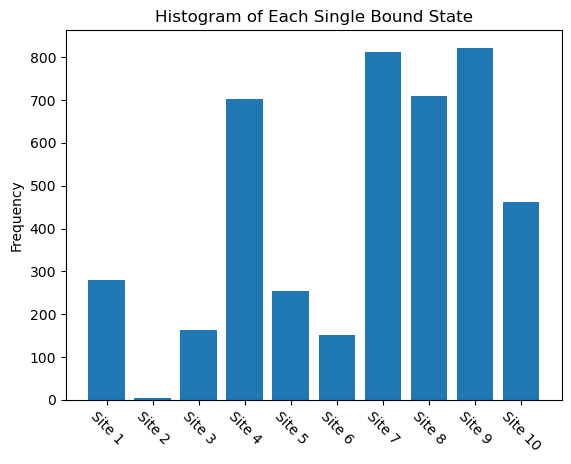

<Figure size 640x480 with 0 Axes>

In [ ]:
site_strings = ["Site " + str(i) for i in np.arange(1,11)]

single_counts = dict([(site, db.num_reads_sites([site])) for site in np.arange(1,11)])

plt.bar(single_counts.keys(),single_counts.values())
plt.xticks(np.arange(1,11), site_strings, rotation=-45)
plt.title('Histogram of Each Single Bound State')
plt.ylabel("Frequency")
plt.show()
plt.clf()

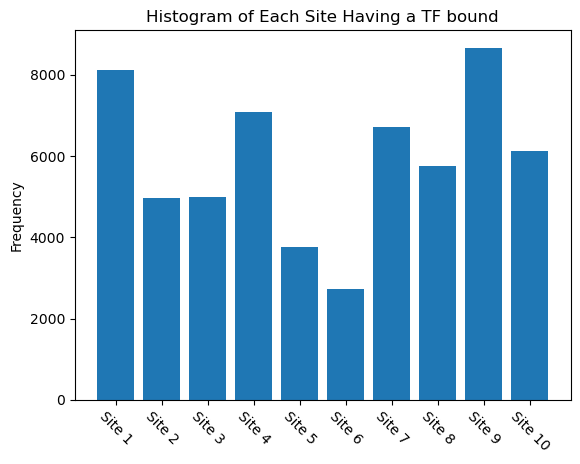

<Figure size 640x480 with 0 Axes>

In [7]:
single_occur = dict([(site, db.num_contains([site])) for site in np.arange(1,11)])

plt.bar(single_occur.keys(),single_occur.values())
plt.xticks(np.arange(1,11), site_strings, rotation=-45)
plt.title('Histogram of Each Site Having a TF bound')
plt.ylabel("Frequency")
plt.show()
plt.clf()

### Begin Comparing State Energies Relative to the Unbound State

In [7]:
import matplotlib
matplotlib.rcParams.update(matplotlib.rcParamsDefault)

In [8]:
# Calculate all pairwise and single bound state energies

energies = np.zeros((10,10),dtype=float)
significance = np.zeros((10,10),dtype=float)
pcut = 0.01

for x in np.arange(10):
    for y in np.arange(10):
        if x==y:
            sites = [0, x+1]
            significance[x,y] = db.p_val(sites)['p']
            n = db.combination_counts(sites)
            f = db.boltzz_factors(n)
            e = db.energy_states(f)
            energies[x,y] = e[tuple([x+1])]
        elif x > y:
            energies[x,y] = np.nan
            significance[x,y] = np.nan
            continue
        else:
            sites = [x+1, y+1]
            s = db.p_val(sites)['p']
            significance[x,y] = s
            if s > pcut:
                energies[x,y] = np.nan
                continue
            n = db.combination_counts(sites)
            f = db.boltzz_factors(n)
            e = db.energy_states(f)
            energies[x,y] = e[tuple([x+1, y+1])]
            
energies_df = pd.DataFrame(
    energies,
    index = np.arange(1,11),
    columns = np.arange(1,11)
)


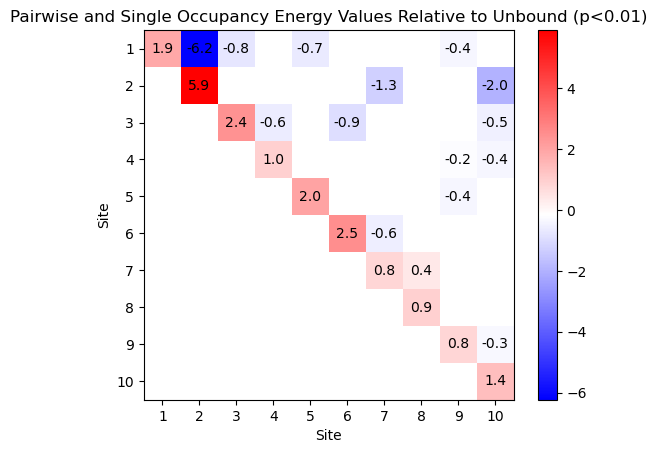

In [9]:
plt.imshow(energies, cmap='bwr')
plt.xticks(np.arange(10),labels=[str(i+1) for i in np.arange(10)])
plt.yticks(np.arange(10),labels=[str(i+1) for i in np.arange(10)])
plt.xlabel("Site")
plt.ylabel("Site")

for x in np.arange(energies.shape[1]):
    for y in np.arange(energies.shape[0]):
        s = str(round(energies[y,x],1))
        if s != 'nan':
            # text = plt.text(x, y, str(s),ha='center',va='center',color='w',weight=1000,size=7)\
            text = plt.text(x, y, str(s),ha='center',va='center',color='black')

plt.title("Pairwise and Single Occupancy Energy Values Relative to Unbound (p<0.01)")
plt.colorbar()
plt.savefig("Figures/single_double_interactions.svg")
plt.show()

In [10]:
energies_df.to_csv("Data/double_energies.csv")

#### Triple Bound State Energies

In [11]:
triple_count = defaultdict(int)
pairs = list(combinations(np.arange(1,11),r=2))
for pair in pairs:
    base = np.array([pair[0],pair[1],0])
    for i in np.arange(1,11):
        if i not in pair:
            base[2] = i
            n = db.num_reads_sites(base)
            triple_count[tuple(base)] = n

counts_triple = np.zeros((45,10))
for row, pair in enumerate(pairs):

    for col in np.arange(10):
        if col+1 <= pair[1]:
            counts_triple[row][col] = np.nan
        else:
            counts_triple[row][col] = triple_count[(pair[0],pair[1],col+1)]

In [12]:
plt.rcParams["figure.figsize"] = (10,20)

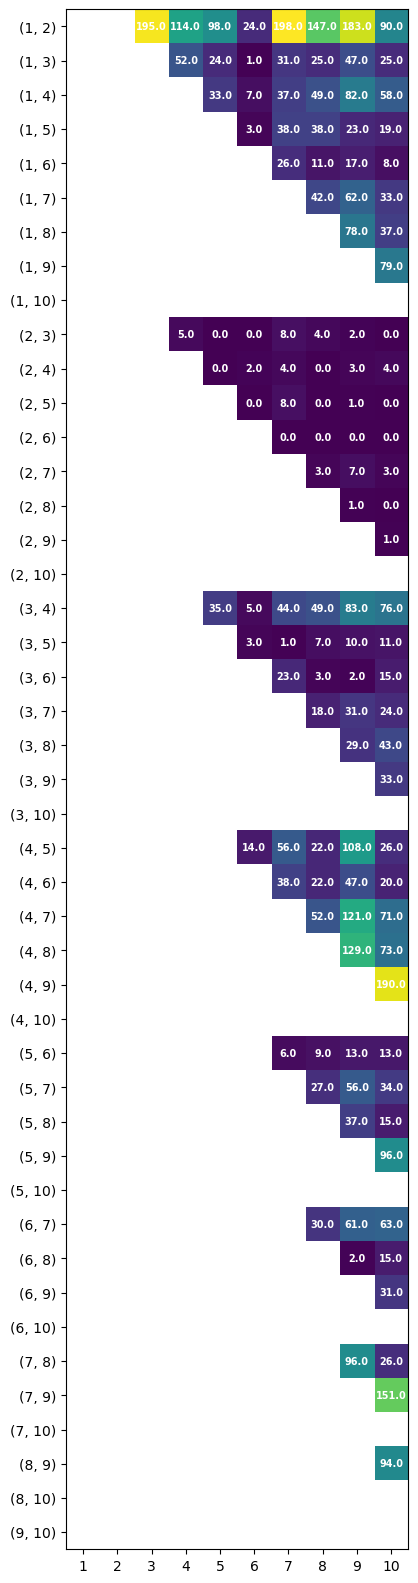

In [13]:

plt.imshow(counts_triple)
plt.xticks(np.arange(10),labels=[str(i+1) for i in np.arange(10)])
plt.yticks(np.arange(45), labels = list(combinations(np.arange(1,11),r=2)))

for x in np.arange(counts_triple.shape[1]):
    for y in np.arange(counts_triple.shape[0]):
        text = plt.text(x, y, str(round(counts_triple[y,x],1)),ha='center',va='center',color='w',weight=1000,size=7)


plt.show()

In [14]:
# Save the data to a csv file
pd.DataFrame(
    counts_triple,
    index = pairs,
    columns = np.arange(1,11)
).to_csv("Data/triple_counts.csv")

In [ ]:
triplets = list(combinations(np.arange(1,11),r=3))
pairs = list(combinations(np.arange(1,11),r=2))
t_energies = dict()
pcut = 0.01
for t in triplets:
    n = db.combination_counts(t)
    f = db.boltzz_factors(n)
    try:
        s = db.p_val(t)['p']
        if s > pcut:
            t_energies[t] = np.nan
        else:
            e = db.energy_states(f)
            t_energies[t] = e[t]
    except:
        print("No instances found of state", t)
        t_energies[t] = np.nan
   
    
energiesT = np.zeros((45,10))
for row, pair in enumerate(pairs):

    for col in np.arange(10):
        if col+1 <= pair[1]:
            energiesT[row][col] = np.nan
        else:
            energiesT[row][col] = t_energies[(pair[0],pair[1],col+1)]

No instances found of state (2, 3, 5)
No instances found of state (2, 3, 6)
No instances found of state (2, 3, 10)
No instances found of state (2, 4, 5)
No instances found of state (2, 4, 8)
No instances found of state (2, 5, 6)
No instances found of state (2, 5, 8)
No instances found of state (2, 5, 10)
No instances found of state (2, 6, 7)
No instances found of state (2, 6, 8)
No instances found of state (2, 6, 9)
No instances found of state (2, 6, 10)
No instances found of state (2, 8, 10)


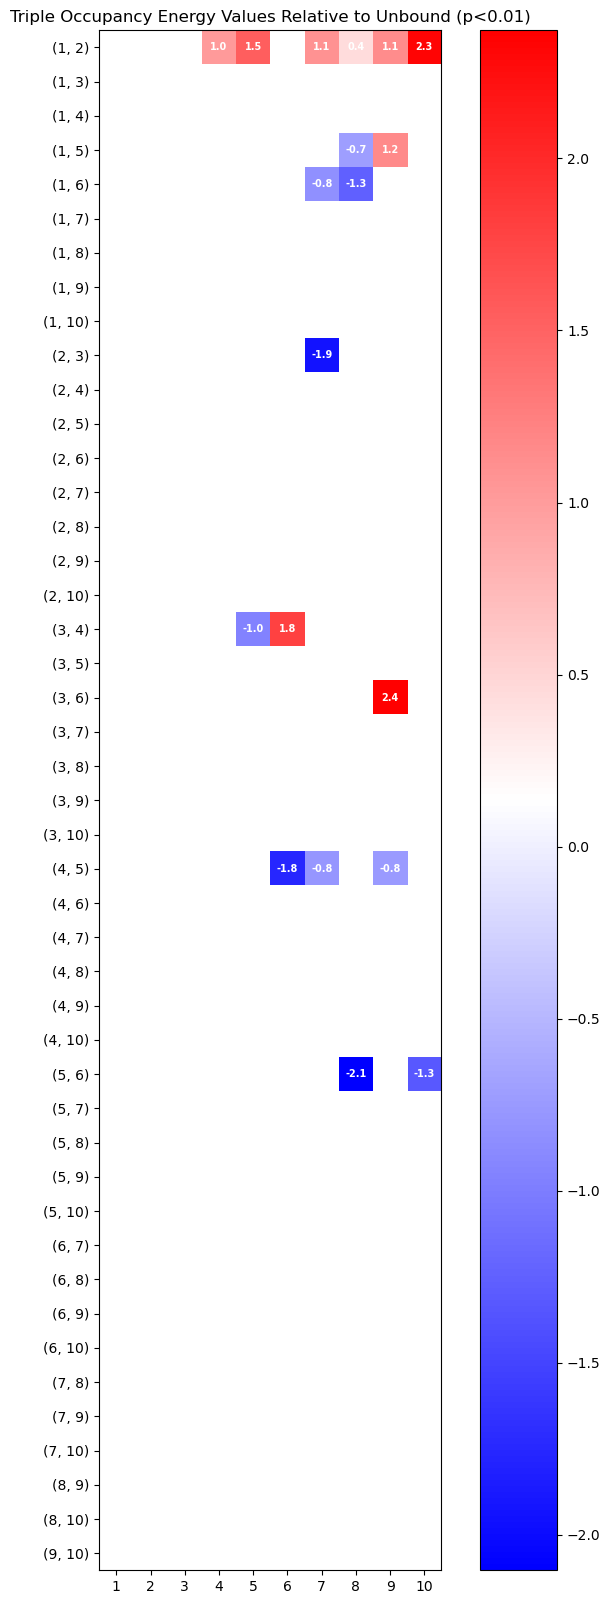

In [16]:
plt.rcParams["figure.figsize"] = (10,20)


plt.imshow(energiesT, cmap='bwr')
plt.xticks(np.arange(10),labels=[str(i+1) for i in np.arange(10)])
plt.yticks(np.arange(45), labels = list(combinations(np.arange(1,11),r=2)))


for x in np.arange(energiesT.shape[1]):
    for y in np.arange(energiesT.shape[0]):
        text = plt.text(x, y, str(round(energiesT[y,x],1)),ha='center',va='center',color='w',weight=1000,size=7)


plt.colorbar()
plt.title("Triple Occupancy Energy Values Relative to Unbound (p<0.01)")
plt.savefig("Figures/tripe_interactions.svg")
plt.show()

In [17]:
pd.DataFrame(
    energiesT,
    index = pairs,
    columns = np.arange(1,11)
).to_csv("Data/triple_energies.csv")

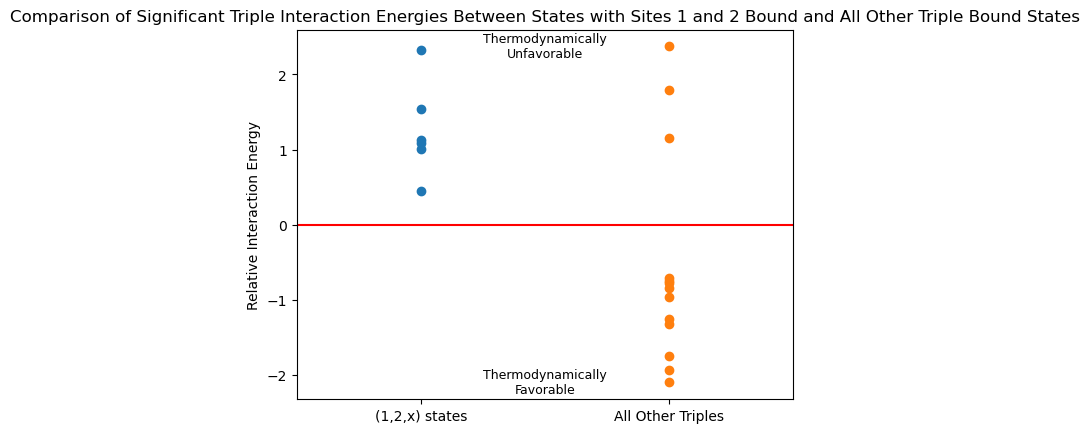

In [18]:
# Seperate Three way interaction into two groups
one_two = []
others = []

for x in np.arange(energiesT.shape[0]):
    for y in np.arange(energiesT.shape[1]):
        e = energiesT[x,y]
        if not np.isnan(e):
            if x == 0:
                one_two.append(e)
            else:
                others.append(e)

# Make plot
matplotlib.rcParams.update(matplotlib.rcParamsDefault)

plt.scatter([0]*len(one_two),one_two)
plt.scatter([1]*len(others), others)

plt.xticks([0,1],labels=['(1,2,x) states', 'All Other Triples'])
plt.xlim(-0.5,1.5)
plt.hlines(0,-0.5,1.5,color='r')
plt.title("Comparison of Significant Triple Interaction Energies Between States with Sites 1 and 2 Bound and All Other Triple Bound States")
plt.ylabel('Relative Interaction Energy')
plt.text(0.5, max(one_two+others), "Thermodynamically\nUnfavorable",ha='center',va='center',color='black',weight=400,size=9)
plt.text(0.5, min(one_two+others), "Thermodynamically\nFavorable",ha='center',va='center',color='black',weight=400,size=9)
plt.savefig("Figures/one_twos-triples.svg")
plt.show()


In [ ]:
quads = list(combinations(np.arange(1,11),r=4))
index = []
data = []
for quad in quads:
    try:
        s = db.p_val(quad)
        # if s['p'] <0.05 and s['n']>40:
        if s['p'] < 0.01:
            n = db.combination_counts(t)
            f = db.boltzz_factors(n)
            e = db.energy_states(f)

            index.append(quad)
            data.append([s['p'],s['z'],s['c'],s['n'], e])
    except:
        # print(quad, "state does not exist")
        pass

quad_df = pd.DataFrame(
    data,
    index=index,
    columns=['p_value', 'z_value', 'expected_counts', 'true_counts']
)

In [20]:
quad_df.sort_values('true_counts',ascending=False,inplace=True)
quad_df.to_csv("Data/quad_energies.csv")